In [1]:
import os
import numpy
import pandas as pd
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [28]:
def read_site_csv(csv_filename):
    csv_data = numpy.genfromtxt(csv_filename, delimiter=',', dtype=str)
    csv_v = csv_data[:, 1]
    csv_v[csv_v=='']='nan'
    csv_v = csv_v.astype(float)
    return csv_data[:, 0], csv_v


def half_hour_to_10min_by_nan(arr_half_hour):
    new_len = 3 * len(arr_half_hour)
    arr_10min = numpy.full(new_len, numpy.nan)
    arr_10min[::3] = arr_half_hour
    return arr_10min


def calculate_kge(simulated, observed):
    print(simulated.shape, observed.shape)
    # 计算均值
    sim_mean = numpy.mean(simulated)
    obs_mean = numpy.mean(observed)

    # 计算标准差
    sim_std = numpy.std(simulated)
    obs_std = numpy.std(observed)

    # 计算相关系数
    corr = numpy.corrcoef(simulated, observed)[0, 1]

    # 计算偏差项
    bias = sim_mean / obs_mean

    # 计算变异性
    variability = sim_std / obs_std

    # 计算KGE
    kge = 1 - numpy.sqrt((corr - 1)**2 + (bias - 1)**2 + (variability - 1)**2)
    
    return kge


def mapping_comparison_single(site_obs, site_cal, fig_title='', axis_min=0.0, axis_max=1.0, save_flag=0):
    plt.figure(figsize=(10,8))
    
    nan_indices = numpy.isnan(site_obs) | numpy.isnan(site_cal)

    # 删除包含 NaN 值的位置
    x_o = site_obs[~nan_indices]
    y_o = site_cal[~nan_indices]
    
    # 绘制1:1参考线
    x_11 = numpy.arange(axis_min, axis_max + 1)
    y_11 = 1 * x_11
    plt.plot(x_11, y_11, color='k', linewidth=1, linestyle='--',)
    
    # 绘制密度散点图
    xy = numpy.vstack([x_o, y_o])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x_, y_, z = x_o[idx], y_o[idx], z[idx]
    z = (z-numpy.min(z))/(numpy.max(z)-numpy.min(z))*100
    # 设置色带
    colors = []
    bounds = [0, 0.05]
    c_count = 100
    color_map = plt.get_cmap('turbo_r',lut = int(c_count/0.85))
    for i in range(c_count):
        colors.append(mpl.colors.rgb2hex(color_map(i)))
        bounds.append(round(100/c_count*(i+1),3))
    colors.append('#dbdbdb')
    colors = colors[::-1]
    cmap=mpl.colors.ListedColormap(colors)
    norm=mpl.colors.BoundaryNorm(bounds,cmap.N) 
    plt.scatter(x_, y_, marker='o', c=z, s=1, cmap=cmap, norm=norm)

    # 使用线性回归模型拟合数据
    model = LinearRegression()
    x = x_o.reshape(-1, 1)
    model.fit(x, y_o)
    y_pred = model.predict(x)
    xx = numpy.arange(axis_min, axis_max + 0.1, 0.05)
    yy_pred = model.coef_[0] * xx + model.intercept_
    
    # 绘制散点图和回归线
    plt.plot(xx, yy_pred, color='red')
    
    # 计算散点个数
    num = numpy.count_nonzero(~numpy.isnan(x))

    # 计算回归方程
    equation = r'$y = {:.2f} \cdot x + {:.2f}$'.format(model.coef_[0], model.intercept_)
#     equation = f'y = {model.coef_[0]:.2f} * x + {model.intercept_:.2f}'

    # 计算评估指标
    kge = calculate_kge(y_o, x_o)
    rmse = numpy.sqrt(mean_squared_error(y_o, y_pred))
    bias = numpy.mean(y_pred - y_o)
    mae = mean_absolute_error(y_o, y_pred)
    r2 = r2_score(y_o, y_pred)

    print('N:', num)
    print('KGE:', kge)
    print('RMSE:', rmse)
    print('Bias:', bias)
    print('MAE', mae)
    print('R²:', r2)

    plt.annotate(f'N: {num:d}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=15)
    plt.annotate(equation, xy=(0.05, 0.90), xycoords='axes fraction', fontsize=15)
    plt.annotate(f'KGE: {kge:.2f}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=15)
    plt.annotate(f'RMSE: {rmse:.2f}', xy=(0.05, 0.80), xycoords='axes fraction', fontsize=15)
    plt.annotate(f'Bias: {bias:.2f}', xy=(0.05, 0.75), xycoords='axes fraction', fontsize=15)
    plt.annotate(f'MAE: {mae:.2f}', xy=(0.05, 0.70), xycoords='axes fraction', fontsize=15)
    plt.annotate(f'R²: {r2:.2f}', xy=(0.05, 0.65), xycoords='axes fraction', fontsize=15)
    
    # 添加标签
    plt.title(fig_title)
#     plt.xlabel('LE observed at site (W/m²)') # axis_min=-50, axis_max=650
#     plt.ylabel('ET calculated by PT-JPL (W/m²)')
    plt.xlabel('ET observed at site (mm/hour)', fontsize=13)
    plt.ylabel('ET estimated by PT-JPL model (mm/hour)', fontsize=13)

    # 显示图形
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim((axis_min, axis_max))
    plt.ylim((axis_min, axis_max))
    plt.colorbar(label='Density').set_ticks([0,20, 40, 60, 80, 100])

    if save_flag:
        plt.savefig(os.path.join(OUTPUT_FOLDER, 'scatterplot_'+ fig_title + '.png'), dpi=300)
    else:
        plt.show()
        plt.clf()

In [4]:
OUTPUT_FOLDER = '/disk2/workspace/20240325'
SITE_LE_FOLDER = '/disk2/workspace/20240326/site_LE_obs'

## Sites

In [5]:
site_infos = [# site, lat, lon, UTC+
    ["CLC", 44.59666667, 123.4702778, 8],
    ["JRC", 31.80683056, 119.2172639, 8],
    ["PDC", 26.6, 106.3166667, 8],
    ["PJC", 40.94138889, 121.9602778, 8],
    ["HZF", 51.78111111, 121.0177778, 8],
    ["ZAG", 32.8, 102.55, 8],
    ["DBB", 41.64397222, 110.3314722, 8],
    ["HBG", 37.61666667, 101.3166667, 8],
#     ["MPM", 22.4982, 114.0292, 8],
    ["BBY", 43.323, 141.8107, 9],
    ["TKY", 36.14616667, 137.4231111, 9],
    ["CRK", 38.20138889, 127.2505556, 9],
    ["GCK", 37.74833333, 127.1622222, 9],
    ["GDK", 37.74888889, 127.1491667, 9],
    ["SIP", 0.395204167, 102.7645506, 7],
    ["SDP", 0.699491389, 102.793305, 7],
    ["ASM", -22.2828, 133.2493, 9],
    ["CPW", -33.6152, 150.7236, 11],
    ["WAR", -43.095, 146.6545, 11]
]

In [38]:
# all sites
site_obs_display_list = []
site_cal_display_list = []
for site_info in site_infos:
    site_name = site_info[0]
#     print(site_name)
    site_output_csv = os.path.join(OUTPUT_FOLDER, site_name + '_PL-JPL_outputs.csv')
    datMMS = pd.read_csv(site_output_csv)

    site_timelist = numpy.array(datMMS.Time)
    site_et_list = numpy.array(datMMS.evapotranspiration).astype(float)
    site_cal_display_list.append(site_et_list)

    site_obs_le_csv = os.path.join(SITE_LE_FOLDER, site_name + '_2018_2019_LE.csv')
    site_obs_timelist, site_obs_le_30min = read_site_csv(site_obs_le_csv)
    site_obs_le = half_hour_to_10min_by_nan(site_obs_le_30min)
    site_obs_display_list.append(site_obs_le)

site_cal_display_list = numpy.concatenate(site_cal_display_list)
site_obs_display_list = numpy.concatenate(site_obs_display_list)
# mean ET every 30 min
site_obs_0 = numpy.copy(site_obs_display_list)
site_obs_0[site_obs_0<0]=numpy.NaN
site_obs_30 = site_obs_0[::3]
site_et_30 = numpy.nanmean(site_cal_display_list.reshape(-1, 3), axis=1)
# mapping_comparison_single(site_obs_30, site_et_30, 'All 18 sites for 2018-2019', axis_min=0, axis_max=650, save_flag=0)

# W/m2 to mm/hour
site_obs_hh_et = numpy.nanmean(site_obs_0.reshape(-1, 6), axis=1)
site_cal_hh_et = numpy.nanmean(site_cal_display_list.reshape(-1, 6), axis=1)
site_obs_h_et = site_obs_hh_et*60*60/2454000
site_cal_h_et = site_cal_hh_et*60*60/2454000

/home/beichen/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/home/beichen/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


(59920,) (59920,)
N: 59920
KGE: 0.4122622819388897
RMSE: 0.14672180371358143
Bias: 1.4644864463680303e-17
MAE 0.10391190312498579
R²: 0.40014476332988314


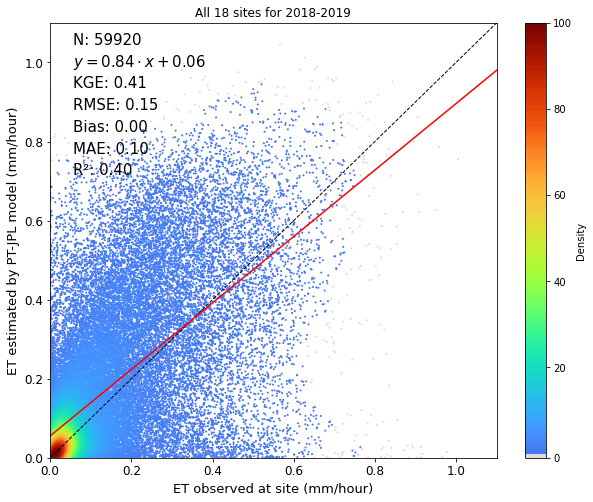

In [29]:
mapping_comparison_single(site_obs_h_et, site_cal_h_et, 'All 18 sites for 2018-2019', axis_min=0, axis_max=1.1, save_flag=1)